In [2]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

from collections import deque, Counter, namedtuple, OrderedDict
import numpy as np
import pandas as pd
from scipy.stats import rankdata, pearsonr, linregress, spearmanr
import scipy.stats as scs
from scipy.special import comb
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
import researchpy as rp


import loc_utils as lut
import vis_utils as vut
from standards import *

rx = RAWXix()
r = RAWix()

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

gcolors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']
colors = ['#43799d', '#cc5b46', '#ffbb00', '#71bc78']

glabels = {0: 'F', 1: 'S'} 
fullglabels = {0: 'Free', 1: 'Strategic'}
clabels = {0: 'i-', 1: 'i+'}
fullclabels = {0: 'uninformed', 1: 'informed'}

def gclabel(g, c):
    return '{}/{}'.format(glabels[g], clabels[c])

tlabels = {
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'R'}

saveloc = '/Users/alexten/Projects/HFSP/fimg'
desktop = '/Users/alexten/Desktop/'

data_path = 'pipeline_data/s3/joint_data.pkl'

def save_it(fig, savedir, figname, save_as='svg', dpi=500, compress=True):
    s = savedir+'/{}.{}'.format(figname, save_as)
    fig.savefig(s, format=save_as, dpi=500)
    if compress:
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))

In [3]:
def linez(d, fname='figure'):
        plt.figure(fname, figsize=[5,3])
        plt.subplot(111)

        for grp in [0, 1]:
            for cnd in [1,0]:
                mask = lut.get_mask(d, {1: grp, 2: cnd})
                N = mask.sum()
                plt.grid(True, zorder=0)
                hw = np.zeros_like(d[mask, 3]) + 1. / d[mask, 3].size
                vut.line_histogram(plt.gca(), 
                                   d[mask, 3], 
                                   bins=np.arange(-1,1.1,.25),
                                   lw=2,
                                   ls='-' if cnd else '--',
                                   label='{}/{} (N = {})'.format(glabels[grp], clabels[cnd], N),
                                   c=gcolors[grp])
                plt.legend()
                plt.xlim(-1.1,1.1)
                plt.ylim(0,.55)
                plt.yticks(np.arange(0,0.6,.1), 
                           np.around(np.arange(0,0.6,.1),1).astype(str),) 
                plt.xlabel("Correlation coefficient")
                plt.ylabel("Relative frequency")
                vut.despine(plt.gca(), 'top,right'.split(','))
        plt.tight_layout()

        
def barz(d, fname='figure'):
    plt.figure(fname, figsize=[7, 5])
    ii = 1
    for grp in [0, 1]:
        for cnd in [1, 0]:
            mask = lut.get_mask(d, {1: grp, 2: cnd})
            N = mask.sum()
            plt.subplot(2,2,ii)
            plt.grid(True, zorder=0)
            hw = np.zeros_like(d[mask, 3]) + 1. / d[mask, 3].size
            plt.hist(d[mask, 3], weights=hw, zorder=3,
                               bins=np.arange(-1,1.1,.25), fc=gcolors[0])
            plt.title('{} / {} (N = {})'.format(fullglabels[grp], fullclabels[cnd], N))
            plt.xlim(-1.1, 1.1)
            plt.ylim(0, .55)
            plt.yticks(np.arange(0, 0.6,.1), 
                       np.around(np.arange(0,0.6,.1),1).astype(str),) 
            plt.xlabel("Correlation coefficient")
            plt.ylabel("Relative frequency")
            vut.despine(plt.gca(), 'top,right'.split(','))
            ii+=1
    plt.tight_layout()

    
def randrank(x, seed=None):
    np.random.seed(seed)
    return rankdata(x + np.random.rand(*x.shape))


def preplongdata(mpath, xpath, save_csv='', pickle=''):
    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    nontest = lut.get_mask(mdata, {r.ix('stage'): 2}, '!=')
    mdata = mdata[nontest, :]
    
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    outdata = []
    order = np.array([1,2,3,4]).reshape(-1, 1)
    
    window = 15
    for sid in sids[:-1]:

        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})

        grp, cnd = xdata[sxmask, xix('grp')][0], xdata[sxmask, xix('cnd')][0]
        sid, grp, cnd = (np.zeros(4)+sid).tolist(), (np.zeros(4)+grp).tolist(), (np.zeros(4)+cnd).tolist()
        fid = mdata[smask, :][:, [r.ix('cat'), r.ix('fam')]]
        fid = [fid[fid[:, 0]==t, 1][0] for t in tasks]

        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]]

        pc_grand = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        
        pc1 = [np.mean(hits[hits[:, 0]==t, 1][:window]) for t in tasks]
        pc2 = [np.mean(hits[hits[:, 0]==t, 1][-window:]) for t in tasks]
        dpc = np.array(pc2) - np.array(pc1)
        dpc[dpc < 0] = 0
        
        tasks, counts = np.unique(mdata[smask, r.ix('cat')], return_counts=True)
        freetime = (counts-15) / np.sum(mdata[smask, r.ix('stage')]==1)
        alltime = counts / np.sum(smask)
        
        switch = mdata[smask, :][60:, [r.ix('cat'),r.ix('switch')]]
        switches_to = np.array([np.logical_and(switch[:,0]==t, switch[:,1]).sum() for t in tasks])
        avstreak = (counts-15) / switches_to
        avstreak[np.isnan(avstreak)] = 0
        
        tord = mdata[smask, :][:60, [r.ix('cat'),r.ix('switch')]]
        tord = tord[tord[:,1].astype(bool), 0]
        
        qblock = []
        for q in 'lrn,int,comp,time,prog,rule,lrn2'.split(','):
            qblock.append(xdata[sxmask, xix('{}_1'.format(q)):xix('{}_4'.format(q))+1].squeeze())   
            
        dblock = [sid, grp, cnd, fid, tasks, tord,
                  pc_grand, pc1, pc2, dpc,
                  alltime, freetime, switches_to, avstreak]
        
        sidblock = np.stack(dblock + qblock, axis=1)

        outdata.append(sidblock)
    
    lcols = 'sid,grp,cnd,fam,tid,tord,pc_grand,pc_first,pc_last,dpc,alltime,freetime,nblocks,avstreak,lrn,int,comp,time,prog,rule,lrn2'.split(',')
    dtypes = 'int,category,category,category,category,int,float,float,float,float,float,float,int,float,int,int,int,int,int,int,int'.split(',')
    outdata = OrderedDict(
        zip(lcols, 
            [pd.Series(d, dtype=dt) for d, dt in zip(np.concatenate(outdata, axis=0).T, dtypes)]
           )
    )
    outdata = pd.DataFrame(outdata)
    outdata.replace(dict(grp={0.0: 'F', 1.0: 'S'}, 
                         cnd={0.0: 'i-', 1.0: 'i+'},
                         fam={1.0: 'Bear', 2.0: 'Bunny', 3.0: 'Green', 4.0: 'Squid'},
                         tid={1.0: '1D', 2.0: 'I1D', 3.0: '2D', 4.0: 'R'}), inplace=True)
    outdata = outdata.astype(dict(zip(lcols, dtypes)))
#     print(outdata.head(16))
    if save_csv:
        print('Saving data to pipeline_data/longdata/{}'.format(save_csv))
        outdata.to_csv('pipeline_data/longdata/{}'.format(save_csv), index=False)
    
    if pickle:
        lut.dopickle('pipeline_data/longdata/{}'.format(pickle), outdata)

        
if 0:
    preplongdata(data_path, 'pipeline_data/s3/extra_data_good_form.pkl', 
                save_csv='long.csv', pickle='long.pkl')

# 1. Selection rates

## 1.1.1. Split by group (lines)

<IPython.core.display.Javascript object>


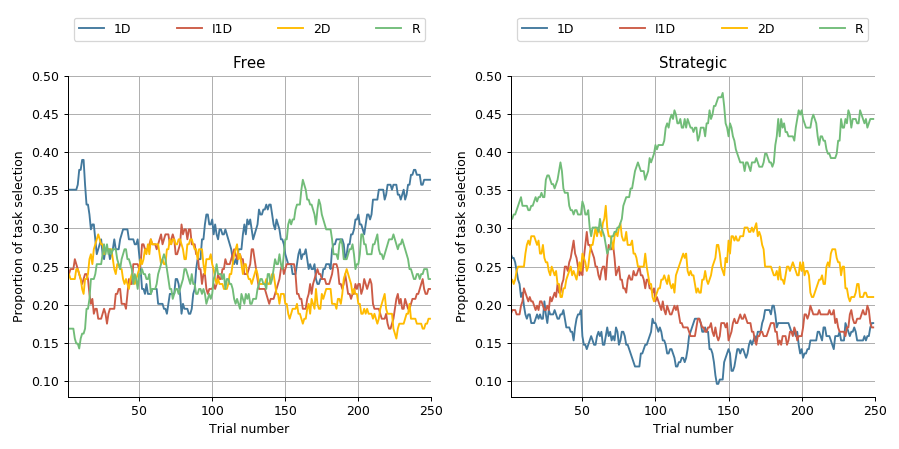

In [3]:
def f111(path, figname, save_to, save_as=None, compress=False):
    mdata = lut.unpickle(path)['main']

    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), 
                                                        r.ix('group'),
                                                        r.ix('cond'),
                                                        r.ix('cat')])

    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    fig = plt.figure(figname, figsize=[10,5])
   
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        
        ax = fig.add_subplot(1,2,1 + grp)
        psels = []
        for i, tsk in enumerate(tasks):
            tmask = np.array([mdata[gmask, r.ix('cat')] == tsk]).reshape([gsids.size, -1])
            psel = np.sum(tmask, axis=0) / gsids.size
            psels.append(psel)
            ax.plot(psel, c=colors[i], label=tlabels[tsk])
            
            ax.set_xlim(1,250)
            ax.set_ylim(.08,.5)
            ax.set_title(fullglabels[grp])
            ax.set_ylabel('Proportion of task selection')
            vut.despine(ax, ['right', 'top'])
            ax.legend(bbox_to_anchor=(0,1,1,0.2), loc='upper left', mode='expand', ncol=4)
            ax.grid(True)
            ax.set_xlabel('Trial number')
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, compress=False)

if 1:
    f111(path = 'pipeline_data/s3/joint_data.pkl',
         figname = 'pselect_G_lines', 
         save_to=saveloc, 
         save_as='')

## 1.1.2. Split by group (stacked)

In [ ]:
def f112(path, figname, save_to, save_as=None, compress=False):
    mdata = lut.unpickle(path)['main']

    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), 
                                                        r.ix('group'),
                                                        r.ix('cond'),
                                                        r.ix('cat')])

    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    fig = plt.figure(figname, figsize=[10,5])
   
    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        
        ax = fig.add_subplot(1,2,1 + grp)
        psels = []
        for i, tsk in enumerate(tasks):
            tmask = np.array([mdata[gmask, r.ix('cat')] == tsk]).reshape([gsids.size, -1])
            psel = np.sum(tmask, axis=0) / gsids.size
            psels.append(psel)
            
        ax.stackplot(np.arange(1,251), psels, colors=colors, 
                     labels=[tlabels[t] for t in tasks])
        ax.set_xlim(1,250)
        ax.set_ylim(0,1)
        ax.set_title(fullglabels[grp])
        ax.set_ylabel('Percentage')
        vut.despine(ax, ['right', 'top', 'left', 'bottom'])
        ax.legend(bbox_to_anchor=(0,1,1,0.2), loc='upper left', mode='expand', ncol=4)
        ax.grid(True, c='w')
        ax.set_xlabel('Trial number')
        
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    f112(path = 'pipeline_data/s3/joint_data.pkl',
         figname = 'pselect_G_stackplot', 
         save_to = saveloc, 
         save_as='svg', compress=0)

## 1.2.1. Split by group and condition

In [ ]:
def f121(path, figname, save_to, save_as=None, compress=False):
    mdata = lut.unpickle(path)['main']

    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), 
                                                        r.ix('group'),
                                                        r.ix('cond'),
                                                        r.ix('cat')])

    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    fig = plt.figure(figname, figsize=[10,5])
   
    for grp in groups:
        for cnd in conds:
            gcmask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('cond'): cnd})
            gcsids = lut.get_unique(mdata[gcmask, :], r.ix('sid'))

            ax = fig.add_subplot(1,2,1 + grp)
            psels = []
            for i, tsk in enumerate(tasks):
                tmask = np.array([mdata[gcmask, r.ix('cat')] == tsk]).reshape([gcsids.size, -1])
                psel = np.sum(tmask, axis=0) / gcsids.size
                psels.append(psel)
                
                ax.plot(psel, c=colors[i], label=tlabels[tsk] if cnd else '', 
                        ls='-' if cnd else '--', alpha=.8)

                ax.set_xlim(1,250)
                ax.set_ylim(.08,.55)
                ax.set_title(fullglabels[grp])
                ax.set_ylabel('Proportion of task selection')
                vut.despine(ax, ['right', 'top'])
                ax.legend(bbox_to_anchor=(0,1,1,0.2), loc='upper left', mode='expand', ncol=4)
                ax.grid(True)
                ax.set_xlabel('Trial number')
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    f121(path = 'pipeline_data/s3/joint_data.pkl',
         figname = 'pselect_GC_lines', 
         save_to=saveloc, save_as='svg', compress=0)

## 1.2.2. Split by group and condition (stacked)

In [ ]:
def free_play_pc2(path, 
                 figname, save_to, save_as=None, compress=False):
    mdata = lut.unpickle(path)['main']

    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), 
                                                        r.ix('group'),
                                                        r.ix('cond'),
                                                        r.ix('cat')])

    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    fig = plt.figure(figname, figsize=[10,10])
   
    for grp in groups:
        for cnd in conds:
            gcmask = lut.get_mask(mdata, {r.ix('group'): grp, r.ix('cond'): cnd})
            gcsids = lut.get_unique(mdata[gcmask, :], r.ix('sid'))

            ax = fig.add_subplot(2,2,1 + grp + 2 * cnd)
            
            psels = []
            for i, tsk in enumerate(tasks):
                tmask = np.array([mdata[gcmask, r.ix('cat')] == tsk]).reshape([gcsids.size, -1])
                psel = np.sum(tmask, axis=0) / gcsids.size
                psels.append(psel)

            ax.stackplot(np.arange(1,251), psels, colors=colors, 
                         labels=[tlabels[t] for t in tasks])
            ax.set_xlim(1,250)
            ax.set_ylim(0,1)
            ax.set_title(fullglabels[grp] + (' / informed' if cnd else ' / uninformed') )
            ax.set_ylabel('Percentage')
            vut.despine(ax, ['right', 'top', 'left', 'bottom'])
            ax.legend(bbox_to_anchor=(0,1,1,0.2), loc='upper left', mode='expand', ncol=4)
            ax.grid(True, c='w')
            ax.set_xlabel('Trial number')
        
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, compress=compress)

if 1:
    free_play_pc2(path = 'pipeline_data/s3/joint_data.pkl',
                  figname = 'pselect_GC_stackplot', 
                  save_to = saveloc, save_as = 'svg', compress = 0)

# 2. Learnability and training performance

### 2.1. Individual-level histograms

In [ ]:
def f2_1(mpath, xpath, figname, seed=None, graphtype='bars', to_desktop=False, save_as='', save_csv=''):
    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    train = lut.get_mask(mdata, {r.ix('stage'): 0})
    D = mdata
    mdata = mdata[train, :]
    
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    outdata = []
    rawoutdata = []
    allsame = []
    for sid in sids:
        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})
        
        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]] 
        lrn = xdata[sxmask, xix('lrn_1'):xix('lrn_4')+1].squeeze()
           

        pcraw = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcranks1 = rankdata([np.mean(hits[hits[:, 0]==t, 1]) for t in tasks], method='average')
        pcranks2 = randrank(pcranks1, seed=seed)
        
        lrnraw = lrn.squeeze()
        
        if np.all(lrnraw == lrnraw[0]) or np.all(pcraw == pcraw[0]):
            rho = 0.0
            if not np.all(pcranks1 == pcranks1[0]): allsame.append(sid)
        else:
            min_, max_ = np.min(lrnraw), np.max(lrnraw)
            if min_ == max_: lrnraw = (lrnraw - 1) / 10
            lrnnorm = (lrnraw - min_) / (max_ - min_)
            lrnranks1 = rankdata(lrnraw, method='average')
            lrnranks2 = randrank(lrnraw, seed=seed)
            rho = pearsonr(pcraw, lrnnorm)[0]
        
        row = xdata[sxmask, :3].squeeze().tolist()
        outdata.append(row + [rho])
        rawoutdata.append(row + pcraw + lrnnorm.tolist())

    outdata = np.array(outdata)
    rawoutdata = np.array(rawoutdata)
    
    if save_csv:
        print('saving data to {}'.format(save_csv))
        np.savetxt(save_csv, outdata, 
                   header = 'sid,grp,cnd,r',
                   fmt = ['%d','%d','%d','%2.8f'],
                   delimiter = ',')

    
    np.set_printoptions(precision=3, suppress=True)
    
    if graphtype=='lines':
        linez(outdata, 'f2')
    elif graphtype=='bars':
        barz(outdata, 'f2')

    if save_as:
        save_it(plt.gcf(), savedir=desktop if to_desk else saveloc, figname='{}_{}'.format(figname, graphtype), 
            save_as=save_as, dpi=500, compress=False)
    
    for grp in [0, 1]:
        for cnd in [1,0]:
            mask = lut.get_mask(outdata, {1: grp, 2: cnd})
            N = mask.sum()
            meanr = outdata[mask, 3].mean()
            
            z = meanr / (1/np.sqrt(N - 3))
            p = scs.norm.cdf(z)
            print('{} / {}: r = {:5.2f}, z = {:5.2f}, p = {:5.2f}' .format(
                glabels[grp], clabels[cnd], meanr, z, p)
                 )


if 1:
    csv = 'R_docs/lrn_dpc_data.csv'

    f_2(mpath = data_path,
       xpath = 'pipeline_data/s3/extra_data_good_form.pkl',
       figname = 'corr_pc_lrn',
       seed = 1,
       graphtype = 'bars',
       save_as = 'png',
       to_desk = True,
       save_csv = csv)

### 2.2. Why peaks at 0?

#### 2.2.1. Distributions of hits ranges

In [ ]:
def f2_2_1(mpath, xpath, figname, seed=None, to_desk=False, save_as='', save_csv=''):
    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    train = lut.get_mask(mdata, {r.ix('stage'): 0})
    D = mdata
    mdata = mdata[train, :]
    
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    outdata = []
    rawoutdata = []
    allsame = []
    for sid in sids:
        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})
        
        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]] 
        lrn = xdata[sxmask, xix('lrn_1'):xix('lrn_4')+1].squeeze()
           

        pcraw = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcranks1 = rankdata([np.mean(hits[hits[:, 0]==t, 1]) for t in tasks], method='average')
        pcranks2 = randrank(pcranks1, seed=seed)
        
        hitsbytask = [np.sum(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcrange = np.max(hitsbytask) - np.min(hitsbytask)
        
        lrnraw = lrn.squeeze()
        
        if np.all(lrnraw == lrnraw[0]) or np.all(pcraw == pcraw[0]):
            rho = 0.0
            if not np.all(pcranks1 == pcranks1[0]): allsame.append(sid)
        else:
            min_, max_ = np.min(lrnraw), np.max(lrnraw)
            if min_ == max_: lrnraw = (lrnraw - 1) / 10
            lrnnorm = (lrnraw - min_) / (max_ - min_)
            lrnranks1 = rankdata(lrnraw, method='average')
            lrnranks2 = randrank(lrnraw, seed=seed)
            rho = pearsonr(pcranks2, lrnranks2)[0]
        
        row = xdata[sxmask, :3].squeeze().tolist()
        outdata.append(row + [rho, pcrange])
        rawoutdata.append(row + pcraw + lrnnorm.tolist())

    outdata = np.array(outdata)
    rawoutdata = np.array(rawoutdata)
    
    if save_csv:
        print('saving data to {}'.format(save_csv))
        np.savetxt(save_csv, outdata, 
                   header = 'sid,grp,cnd,r,range',
                   fmt = ['%d','%d','%d','%2.8f'],
                   delimiter = ',')
    
    # ====================================== Plots ======================================

    fig = plt.figure(num=figname, figsize=[8,8])
    
    ii = 3
    for grp in [0, 1]:
        for cnd in [1, 0]:
            mask = lut.get_mask(outdata, {1: grp, 2: cnd})
            pcrange, rho = outdata[mask, 4], np.abs(outdata[mask, 3])
            ax = fig.add_subplot(3,2,ii)
            ax.hist(pcrange, weights=np.zeros_like(pcrange) + 1. /pcrange.size,
                bins=np.arange(0,12.1,1), fc=gcolors[0], zorder=3)
            ax.set_title('{} / {} (N = {})'.format(
                fullglabels[grp], fullclabels[cnd], pcrange.size))
            ax.grid(True, zorder=0)
            vut.despine(ax, ['top', 'right'])
            ax.set_ylabel('Relative frequency')
            ax.set_xlabel('Hits range')
            ax.set_ylim([0,.25])
            ii += 1

    pcrange, rho = outdata[:, 4], np.abs(outdata[:, 3])
    ax_overall = fig.add_subplot(3,1,1)
    ax_overall.hist(pcrange, weights=np.zeros_like(pcrange) + 1. /pcrange.size,
                    bins=np.arange(0,12.1,1), fc=gcolors[0], zorder=3)
    ax_overall.set_title('All groups and conditions (N = {})'.format(np.size(pcrange)))
    ax_overall.grid(True, zorder=0)
    ax_overall.set_ylim([0,.25])
    vut.despine(ax_overall, ['top', 'right'])
    ax_overall.set_ylabel('Relative frequency')
    ax_overall.set_xlabel('Hits range') 
            
    fig.tight_layout()
    
            
    if save_as:
        save_it(fig, savedir=desktop if to_desk else saveloc, figname=figname, 
            save_as=save_as, dpi=500, compress=False)
if 1:
    csv = 'R_docs/lrn_dpc_data.csv'

    f2_2_1(mpath = data_path,
       xpath = 'pipeline_data/s3/extra_data_good_form.pkl',
       figname = 'hist_rangepc',
       seed = 1,
       save_as = '',
       to_desk = True)

#### 2.2.2. Correlations between hits ranges and LRN-PC rhos

In [ ]:
def f2_2_2(mpath, xpath, figname, seed=None, to_desk=False, save_as='', save_csv=''):
    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    train = lut.get_mask(mdata, {r.ix('stage'): 0})
    D = mdata
    mdata = mdata[train, :]
    
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    outdata = []
    rawoutdata = []
    allsame = []
    for sid in sids:
        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})
        
        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]] 
        lrn = xdata[sxmask, xix('lrn_1'):xix('lrn_4')+1].squeeze()
           
        pcraw = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcranks1 = rankdata([np.mean(hits[hits[:, 0]==t, 1]) for t in tasks], method='average')
        pcranks2 = randrank(pcranks1, seed=seed)
        
        hitsbytask = [np.sum(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcrange = np.max(hitsbytask) - np.min(hitsbytask)
        
        lrnraw = lrn.squeeze()
        
        if np.all(lrnraw == lrnraw[0]) or np.all(pcraw == pcraw[0]):
            rho = 0.0
            if not np.all(pcranks1 == pcranks1[0]): allsame.append(sid)
        else:
            min_, max_ = np.min(lrnraw), np.max(lrnraw)
            if min_ == max_: lrnraw = (lrnraw - 1) / 10
            lrnnorm = (lrnraw - min_) / (max_ - min_)
            lrnranks1 = rankdata(lrnraw, method='average')
            lrnranks2 = randrank(lrnraw, seed=seed)
            rho = pearsonr(pcranks2, lrnranks2)[0]
        
        row = xdata[sxmask, :3].squeeze().tolist()
        outdata.append(row + [rho, pcrange])
        rawoutdata.append(row + pcraw + lrnnorm.tolist())

    outdata = np.array(outdata)
    rawoutdata = np.array(rawoutdata)
    
    if save_csv:
        print('saving data to {}'.format(save_csv))
        np.savetxt(save_csv, outdata, 
                   header = 'sid,grp,cnd,r,range',
                   fmt = ['%d','%d','%d','%2.8f'],
                   delimiter = ',')
    
    # ====================================== Plots ======================================

    fig = plt.figure(num=figname, figsize=[8,9])
    
    ii = 3
    for grp in [0, 1]:
        for cnd in [1, 0]:
            ax = fig.add_subplot(3,2,ii)
            mask = lut.get_mask(outdata, {1: grp, 2: cnd})
            pcrange, rho = outdata[mask, 4], outdata[mask, 3]
            pcrange[pcrange<=4] = 4
            pcrange[pcrange>=9] = 9
            
            rangevals = np.unique(pcrange)
            rhomeans = [np.mean(rho[pcrange==rangeval]) for rangeval in rangevals]
            rhosd = [scs.sem(rho[pcrange==rangeval]) for rangeval in rangevals]

            ax.errorbar(x=rangevals, y=rhomeans, yerr=rhosd, c='k', lw=2, capsize=5)
            ax.set_xticks(rangevals)
            ax.set_xticklabels('<=4,5,6,7,8,>=9'.split(','))
            ax.grid(True, axis='y')
            ax.set_ylim([-.9,.3])
            vut.despine(ax, ['top', 'right'])
            corr, pval  = pearsonr(pcrange,rho)
            ax.set_title('{} / {}\n(r = {:0.4f}, p = {:0.4f})'.format(
                fullglabels[grp], fullclabels[cnd], corr, pval))
            ax.set_ylabel('Spearman correlation coefficient')
            ax.set_xlabel('Hits range')
            ii += 1

    pcrange, rho = outdata[:, 4], outdata[:, 3]

    ax_overall = fig.add_subplot(3,1,1)    
    pcrange[pcrange<=3] = 3
    pcrange[pcrange>=10] = 10
    
    rangevals = np.unique(pcrange)
    rhomeans = [np.mean(rho[pcrange==rangeval]) for rangeval in rangevals]
    rhosd = [scs.sem(rho[pcrange==rangeval]) for rangeval in rangevals]
    
    ax_overall.errorbar(x=rangevals, y=rhomeans, yerr=rhosd, c='k', lw=2, capsize=5)
    ax_overall.set_xticks(rangevals)
    ax_overall.set_xticklabels('<=3,4,5,6,7,8,9,>=10'.split(','))
    ax_overall.grid(True, axis='y')
    ax_overall.set_ylim([-.7,.1])
    vut.despine(ax_overall, ['top', 'right'])
    corr, pval = pearsonr(pcrange,rho)
    ax_overall.set_title('All groups and conditions\n(r = {:0.4f}, p = {:0.4f})'.format(corr, pval))
    ax_overall.set_ylabel('Spearman correlation coefficient')
    ax_overall.set_xlabel('Hits range')     
            
    fig.tight_layout()
            
    if save_as:
        save_it(fig, savedir=desktop if to_desk else saveloc, figname=figname, 
            save_as=save_as, dpi=500, compress=False)
if 1:
    csv = 'R_docs/lrn_dpc_data.csv'

    f2_2_2(mpath = data_path,
       xpath = 'pipeline_data/s3/extra_data_good_form.pkl',
       figname = 'corr_rangepc_rho2',
       seed = 1,
       save_as = '',
       to_desk = True)

#### 2.2.3. Can peaks at 0 be explained by homogeneous performance during training

In [ ]:
def f2_2_3(mpath, xpath, figname, seed=None, to_desk=False, save_as='', save_csv=''):
    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    train = lut.get_mask(mdata, {r.ix('stage'): 0})
    D = mdata
    mdata = mdata[train, :]
    
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    outdata = []
    rawoutdata = []
    allsame = []
    for sid in sids:
        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})
        
        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]] 
        lrn = xdata[sxmask, xix('lrn_1'):xix('lrn_4')+1].squeeze()
           
        pcraw = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcranks1 = rankdata([np.mean(hits[hits[:, 0]==t, 1]) for t in tasks], method='average')
        pcranks2 = randrank(pcranks1, seed=seed)
        
        hitsbytask = [np.sum(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcrange = np.max(hitsbytask) - np.min(hitsbytask)
        
        lrnraw = lrn.squeeze()
        
        if np.all(lrnraw == lrnraw[0]) or np.all(pcraw == pcraw[0]):
            rho = 0.0
            if not np.all(pcranks1 == pcranks1[0]): allsame.append(sid)
        else:
            min_, max_ = np.min(lrnraw), np.max(lrnraw)
            if min_ == max_: lrnraw = (lrnraw - 1) / 10
            lrnnorm = (lrnraw - min_) / (max_ - min_)
            lrnranks1 = rankdata(lrnraw, method='average')
            lrnranks2 = randrank(lrnraw, seed=seed)
            rho = pearsonr(pcranks2, lrnranks2)[0]
        
        row = xdata[sxmask, :3].squeeze().tolist()
        outdata.append(row + [rho, pcrange])
        rawoutdata.append(row + pcraw + lrnnorm.tolist())

    outdata = np.array(outdata)
    rawoutdata = np.array(rawoutdata)
    
    if save_csv:
        print('saving data to {}'.format(save_csv))
        np.savetxt(save_csv, outdata, 
                   header = 'sid,grp,cnd,r,range',
                   fmt = ['%d','%d','%d','%2.8f'],
                   delimiter = ',')
    
    # ====================================== Plots ======================================

    fig = plt.figure(num=figname, figsize=[8,5])
    
    ii = 3
    cutoff = 6
    for sign in ('<','>='):
        ax = fig.add_subplot(2,2,ii)
        mask = lut.get_mask(outdata, {4: cutoff}, sign)
        rho = outdata[mask, 3]
        ax.hist(rho, bins=np.arange(-1,1.1,.25),
                weights=np.zeros_like(rho) + 1. /rho.size, fc=gcolors[0], zorder=3)
        ax.set_title('Hits range {} {} (N = {})'.format(sign, cutoff, mask.sum()))
        ax.grid(True, zorder=0)
        vut.despine(ax, ['top', 'right'])
        ax.set_ylabel('Relative frequency')
        ax.set_xlabel('Correlation coefficient')
        ax.set_ylim([0,.55])
        ii += 1

    ax = fig.add_subplot(2,1,1)
    rho = outdata[:, 3]
    ax.hist(rho, bins=np.arange(-1,1.1,.25),
            weights=np.zeros_like(rho) + 1. /rho.size, fc=gcolors[0], zorder=3)
    ax.set_title('Overall (N = {})'.format(rho.size))
    ax.grid(True, zorder=0)
    vut.despine(ax, ['top', 'right'])
    ax.set_ylabel('Relative frequency')
    ax.set_xlabel('Correlation coefficient')
    ax.set_ylim([0,.55])
            
    fig.tight_layout()
            
    if save_as:
        save_it(fig, savedir=desktop if to_desk else saveloc, figname=figname, 
            save_as=save_as, dpi=500, compress=False)


if 1:
    f2_2_3(mpath = data_path,
       xpath = 'pipeline_data/s3/extra_data_good_form.pkl',
       figname = 'corr_PCrank-LRNrank_by_PCrange_6',
       seed = 1,
       save_as = 'png',
       to_desk = True)

# 3. Learnability, performance, and change in performance

<IPython.core.display.Javascript object>


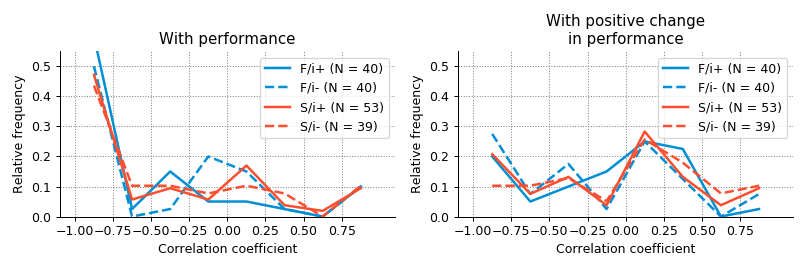

In [4]:
def f3(mpath, xpath, figname, to_desk=False, seed=None, graphtype='bars', save_as='', save_csv=''):

    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    train = lut.get_mask(mdata, {r.ix('stage'): 0})
    D = mdata
    mdata = mdata[train, :]
    
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    outdata = []
    rawoutdata = []
    for sid in sids:
        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})
        
        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]] 
        lrn = xdata[sxmask, xix('lrn_1'):xix('lrn_4')+1].squeeze()
           
        pcraw = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcranks1 = rankdata([np.mean(hits[hits[:, 0]==t, 1]) for t in tasks], method='average')
        pcranks2 = randrank(pcranks1, seed=seed)
        
        pcraw1 = [np.mean(hits[hits[:, 0]==t, 1][:5]) for t in tasks]
        pcraw2 = [np.mean(hits[hits[:, 0]==t, 1][10:]) for t in tasks]
        dpcraw = np.array(pcraw2) - np.array(pcraw1)
        dpcraw[dpcraw < 0] = 0
        dpcranks1 = rankdata(dpcraw, method='average')
        dpcranks2 = randrank(dpcranks1, seed=seed)
        
        hitsbytask = [np.sum(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcrange = np.max(hitsbytask) - np.min(hitsbytask)
        
        lrnraw = lrn.squeeze()
        
        if np.all(lrnraw == lrnraw[0]):
            rho_pc, rho_dpc = 0.0, 0.0
        else:
            min_, max_ = np.min(lrnraw), np.max(lrnraw)
            if min_ == max_: lrnraw = (lrnraw - 1) / 10
            lrnnorm = (lrnraw - min_) / (max_ - min_)
            lrnranks1 = rankdata(lrnraw, method='average')
            lrnranks2 = randrank(lrnraw, seed=seed)
            rho_pc = pearsonr(pcranks2, lrnranks2)[0] if not np.all(pcraw == pcraw[0]) else 0.0
            rho_dpc = pearsonr(dpcranks2, lrnranks2)[0] if not np.all(dpcraw == dpcraw[0]) else 0.0
        row = xdata[sxmask, :3].squeeze().tolist()
        outdata.append(row + [pcrange, rho_pc, rho_dpc])
        rawoutdata.append(row + pcraw + lrnnorm.tolist())

    outdata = np.array(outdata)
    rawoutdata = np.array(rawoutdata)
    lcols = 'sid,grp,cnd,range,rpc,rdpc'.split(',')
    lix = lcols.index
    
    if save_csv:
        print('saving data to {}'.format(save_csv))
        np.savetxt(save_csv, outdata, 
                   header = ','.join(lcols),
                   comments = '',
                   fmt = ['%d','%d','%d','%2.8f','%2.8f','%2.8f'],
                   delimiter = ',')

    # ====================================== Plots ======================================

    fig = plt.figure(num=figname, figsize=[9,3])
    
    cutoff = 6
    m = lut.get_mask(outdata, {lix('range'): cutoff}, '>=')
    cutdata = outdata[m, :]

    for ii, k in enumerate(['rpc', 'rdpc'], start=1):
        plt.subplot(1,2,ii)
        plt.title('With performance' if k=='rpc' else 'With positive change\nin performance')
        for grp in [0, 1]:
            for cnd in [1,0]:
                mask = lut.get_mask(cutdata, {lix('grp'): grp, lix('cnd'): cnd})
                N = mask.sum()
                plt.grid(True, zorder=0)
                hw = np.zeros_like(cutdata[mask, lix(k)]) + 1. / cutdata[mask, lix(k)].size
                vut.line_histogram(plt.gca(), 
                                   cutdata[mask, lix(k)], 
                                   bins=np.arange(-1,1.1,.25),
                                   lw=2,
                                   ls='-' if cnd else '--',
                                   label='{}/{} (N = {})'.format(glabels[grp], clabels[cnd], N),
                                   c=gcolors[grp])
                plt.legend()
                plt.xlim(-1.1,1.1)
                plt.ylim(0,.55)
                plt.yticks(np.arange(0,0.6,.1), 
                           np.around(np.arange(0,0.6,.1),1).astype(str),) 
                plt.xlabel("Correlation coefficient")
                plt.ylabel("Relative frequency")
                vut.despine(plt.gca(), 'top,right'.split(','))
    fig.tight_layout()
            
    if save_as:
        save_it(fig, savedir=desktop if to_desk else saveloc, figname=figname, 
            save_as=save_as, dpi=500, compress=False)


if 1:
    f3(mpath = data_path,
       xpath = 'pipeline_data/s3/extra_data_good_form.pkl',
       figname = 'corrs_LRNrank_PCrank_dPC_rank',
       seed = 1,
       save_as = '',
       save_csv = '')#'R_docs/lrn_pc_dpc_data.csv')

# 4. Distributions of time allocations

In [ ]:
def f4(path, figname, save_to=None, save_as=None, compress=True):
    data = lut.unpickle(path)['main']

    G, T, S = [r.ix(x) for x in ('group', 'cat', 'sid')]
    groups, tasks, sids = lut.get_unique(data, [G, T, S])
    
    freeplay = lut.get_mask(data, {r.ix('stage'): 1})
    data = data[freeplay, :]
    data[:, r.ix('trial')] -= 60
    
    fig = plt.figure(num=figname, figsize=[9,3])
    
    by_group = {}
    for grp in groups:
        ax = fig.add_subplot(1,2,1 + grp)
        
        gmask = lut.get_mask(data, {G: grp})
        gsids = lut.get_unique(data[gmask,:], S)
        
        by_group[grp] = {1:[],2:[],3:[],4:[]}
        for sid in gsids:
            mask = lut.get_mask(data, {S: sid})
            subj_tasks, counts = np.unique(data[mask, T], return_counts=True)
            proportions = counts / np.sum(counts)
            
            for tsk in tasks:
                by_group[grp][tsk].append(
                    proportions[np.where(subj_tasks==tsk)][0] if tsk in subj_tasks else 0
                )
                
        ax.set_title(fullglabels[grp] + ' (N = {})'.format(gsids.shape[0]))
        for tsk in tasks:
            
            ax.set_xlabel('Time spent on task (%)')
            ax.set_ylabel('Proportion of participants')
            ax.set_ylim(0,.5)
            vut.line_histogram(ax, np.array(by_group[grp][tsk])*100, 
                               bins=np.arange(0,120,10), 
                               label=tlabels[tsk],
                               c=colors[tsk-1], lw=2, alpha=.8)
        ax.legend()
        
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=compress)
 

if 1:
    f4(
        path='pipeline_data/s3/joint_data.pkl',
        figname='selection_rates'.replace(' ', '_'),
        save_to=saveloc,
        save_as='svg'
    )

# 5. Learnability regression at a group level

### 5.1. Prepare data for R

In [3]:
def f5(mpath, xpath, figname, seed=None, graphtype='bars', save_as='', save_csv=''):
    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    train = lut.get_mask(mdata, {r.ix('stage'): 0})
    D = mdata
    mdata = mdata[train, :]
    
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    outdata = []
    allsame = []
    order = np.array([1,2,3,4]).reshape(-1, 1)
#     lut.print_arr(mdata, cols=r.cols, nonints=['rt'])
    for sid in sids[:-1]:
        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})
        
        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]]
        lrn = xdata[sxmask, xix('lrn_1'):xix('lrn_4')+1].squeeze()
           
        pcraw = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcranks1 = rankdata([np.mean(hits[hits[:, 0]==t, 1]) for t in tasks], method='average')
        pcranks2 = randrank(pcranks1, seed=seed).reshape([-1,1])
        
        pcraw1 = [np.mean(hits[hits[:, 0]==t, 1][:5]) for t in tasks]
        pcraw2 = [np.mean(hits[hits[:, 0]==t, 1][10:]) for t in tasks]
        dpcraw = np.array(pcraw2) - np.array(pcraw1)
        dpcraw[dpcraw < 0] = 0
        dpcranks1 = rankdata(dpcraw, method='average')
        dpcranks2 = randrank(dpcranks1, seed=seed).reshape([-1,1])
        
        lrnraw = lrn.squeeze()
        lrnranks1 = rankdata(lrn.squeeze(), method='average')
        lrnranks2 = randrank(lrnraw, seed=seed).reshape([-1,1])       
        
        tid = mdata[smask, r.ix('fam')][list(range(0,60,15))].astype(int).reshape([-1,1])
        tdummy = np.zeros([4,4])
        tdummy[np.arange(tid.size), tid.squeeze()-1] = 1
        
        bindex = np.tile(xdata[sxmask, :3].squeeze(), [4,1])
        block = np.concatenate([bindex, lrnranks2, dpcranks2, pcranks2, tdummy, order, tid], axis=1)
        outdata.append(block)
    
    outdata = np.concatenate(outdata, axis=0)
    colnames = 'sid,grp,cnd,lrn,dpc,pc,t1,t2,t3,t4,ord,tid'
    print(outdata[:10,:])
    
    if save_csv:
        print('saving data to {}'.format(save_csv))
        np.savetxt(save_csv, outdata, 
                   header = colnames,
                   fmt = ['%d','%d','%d','%d','%2.6f','%2.6f','%d','%d','%d','%d','%d','%d'],
                   delimiter = ',')

if 1:
    f5(mpath = data_path,
       xpath = 'pipeline_data/s3/extra_data_good_form.pkl',
       figname = 'lrn_reg_analysis',
       seed = 1,
       save_csv = 'R_docs/lrn_reg_data.csv')

[[0. 0. 0. 1. 3. 4. 0. 1. 0. 0. 1. 2.]
 [0. 0. 0. 3. 4. 2. 0. 0. 0. 1. 2. 4.]
 [0. 0. 0. 4. 1. 1. 1. 0. 0. 0. 3. 1.]
 [0. 0. 0. 2. 2. 3. 0. 0. 1. 0. 4. 3.]
 [1. 0. 0. 3. 4. 2. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 4. 3. 4. 0. 0. 1. 0. 2. 3.]
 [1. 0. 0. 1. 1. 3. 0. 0. 0. 1. 3. 4.]
 [1. 0. 0. 2. 2. 1. 0. 1. 0. 0. 4. 2.]
 [2. 0. 0. 1. 4. 4. 0. 0. 1. 0. 1. 3.]
 [2. 0. 0. 4. 3. 3. 1. 0. 0. 0. 2. 1.]]
saving data to R_docs/lrn_reg_data.csv


### 5.2. Learnability ranks by monster family

<IPython.core.display.Javascript object>


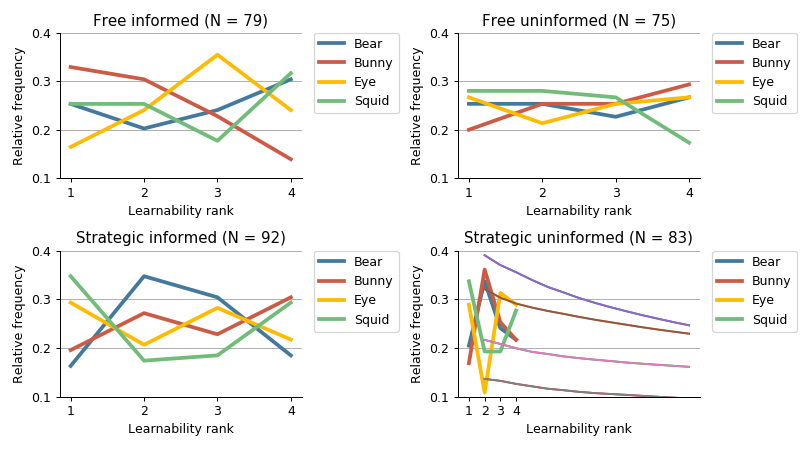

In [4]:
def plot_panel(d, l):
    for i, tsk in enumerate([1,2,3,4]):
        plt.plot([1,2,3,4], d[i], c=colors[i], label=l[i], lw=3)
        plt.xticks([1,2,3,4], '1,2,3,4'.split(','))
    
    plt.grid(True, axis='y')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    vut.despine(plt.gca(), ['right','top'])
    
    
def f5_2():
    plt.figure('f5.2', figsize=[9,5])
    l = 'Bear,Bunny,Eye,Squid'.split(',')
    ii = 1
    for grp in [0, 1]:
        for cnd in [1, 0]:
            plt.subplot(2, 2, ii)
            d = np.loadtxt('R_docs/lrnranks_by_task_g{}c{}.csv'.format(grp,cnd), 
                           skiprows=1, dtype=int, delimiter=',')
            x = np.zeros([4, 4])
            for tsk in [1, 2, 3, 4]:
                for lrn in [1, 2, 3, 4]:
                    x[tsk-1, lrn-1] = d[np.logical_and(d[:,1]==tsk, d[:,2]==lrn), -1]
            plot_panel(np.array(x)/np.sum(x, axis=0), l)
            plt.ylim(.10,.40)
            plt.xlabel('Learnability rank')
            plt.ylabel('Relative frequency')
            plt.title('{} {} (N = {})'.format(fullglabels[grp], fullclabels[cnd], int(np.sum(x, axis=0)[0])))
            ii += 1

    
if 1:
    f5_2()

# 6. Learnability and performance at a task level

In [5]:
def f6(mpath, xpath, figname, seed=None, to_desk=False, save_as='', save_csv=''):

    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    train = lut.get_mask(mdata, {r.ix('stage'): 0})
    D = mdata
    mdata = mdata[train, :]
    
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    rawoutdata = []
    for sid in sids:
        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})
        
        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]] 
        lrn = xdata[sxmask, xix('lrn_1'):xix('lrn_4')+1].squeeze()
           
        pcraw = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        
        
        hitsbytask = [np.sum(hits[hits[:, 0]==t, 1]) for t in tasks]
        pcrange = np.max(hitsbytask) - np.min(hitsbytask)
        
        lrnraw = lrn.squeeze()

        row = xdata[sxmask, :3].squeeze().tolist()

        rawoutdata.append(row + [pcrange] + pcraw + lrnraw.tolist())

    rawoutdata = np.array(rawoutdata)
    
    lcols = 'sid,grp,cnd,range,pc1,pc2,pc3,pc4,lrn1,lrn2,lrn3,lrn4'.split(',')
    lix = lcols.index
    
#     rawoutdata = rawoutdata[rawoutdata[:, lix('range')]>=6, :]

#     lut.print_arr(rawoutdata, cols=lcols, nonints='pc1,pc2,pc3,pc4'.split(','))
    
    if save_csv:
        print('saving data to {}'.format(save_csv))
        np.savetxt(save_csv, rawoutdata, 
                   header = ','.join(lcols),
                   comments = '',
                   fmt = ['%d','%d','%d','%d','%2.8f','%2.8f','%2.8f','%2.8f','%2.8f','%2.8f','%2.8f','%2.8f'],
                   delimiter = ',')

    # ====================================== Plots ======================================
    fig = plt.figure(figname, figsize=[9,5])
    
    ii = 1
    tasks = [1,2,3,4]
    for grp in [0, 1]:
        for cnd in [1, 0]:
            ax = fig.add_subplot(2,2,ii)
            ax.grid(True, zorder=0)
            mask = lut.get_mask(rawoutdata, {1: grp, 2: cnd})
            for tsk in [1,2,3,4]:
            
                pc, lrn = rawoutdata[mask, lix('pc{}'.format(tsk))], rawoutdata[mask, lix('lrn{}'.format(tsk))]
                pcvals = np.unique(pc)
                lrnmeans = np.array([np.mean(lrn[pc==pcval]) for pcval in pcvals])
                lrnsd = [scs.sem(lrn[pc==pcval]) for pcval in pcvals]
                
# Uncomment to bin the scores
#                 pcvals = np.arange(0,1.01,0.1)
#                 lrnmeans = np.array([np.mean(lrn[np.logical_and(pc>=pcval0,pc<pcval1)]) for pcval0, pcval1 in zip(pcvals[:-1],pcvals[1:])])

                ax.plot(np.around(pcvals,2)[:-1], lrnmeans, c=colors[tsk-1], label=tlabels[tsk], 
                        marker='o', ms=3, alpha=.7)
#                 ax.fill_between(np.around(pcvals,2), lrnmeans-lrnsd, lrnmeans+lrnsd, color=colors[tsk-1], alpha=.3)
            ii += 1
            ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            ax.set_title('{} / {}'.format(fullglabels[grp], fullclabels[cnd]))
            ax.set_xlim(0, 1.1)
            ax.set_ylim(0.5, 11)
            vut.despine(ax, ['right','top'])
    print(pcvals)
    fig.tight_layout()
            
    if save_as:
        save_it(fig, savedir=desktop if to_desk else saveloc, figname=figname, 
            save_as=save_as, dpi=500, compress=False)


if 1:
    f6(mpath = data_path,
       xpath = 'pipeline_data/s3/extra_data_good_form.pkl',
       figname = 'LRNraw_PCraw',
       seed = 1,
       to_desk = True,
       save_as = '',
       save_csv = '')#'R_docs/LRNraw_PCraw.csv')

<IPython.core.display.Javascript object>

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (11,) and (12,)

# 9. Treatment effects on self-reports

In [24]:
def f9(path, figname='1'):
    
    df = lut.unpickle(path)
    print(df.columns)
    print(rp.summary_cont(df['freetime'].groupby([df['grp'], df['tid']])))
    
#     results = ols('lrn2 ~ int + C(grp) + C(cnd) + C(tid) + int:C(grp) + int:C(cnd) + int:C(tid)', data=outdata).fit()
#     results = ols('pc_grand ~ int + C(grp) + C(cnd) + C(tid) + int:C(grp) + int:C(cnd) + int:C(tid)', data=outdata).fit()
    
#     print(results.summary())


if 1:
    f9(path = 'pipeline_data/longdata/long.pkl',
       figname='1')


Index(['sid', 'grp', 'cnd', 'fam', 'tid', 'tord', 'pc_grand', 'pc_first', 'pc_last', 'dpc', 'alltime', 'freetime', 'nblocks', 'avstreak', 'lrn', 'int', 'comp', 'time', 'prog', 'rule', 'lrn2'], dtype='object')


           N      Mean        SD        SE  95% Conf.  Interval
grp tid                                                        
F   1D   154  0.287669  0.237171  0.019112   0.250088  0.325250
    2D   154  0.228609  0.160937  0.012969   0.203108  0.254111
    I1D  154  0.232801  0.187021  0.015071   0.203166  0.262436
    R    154  0.250921  0.199892  0.016108   0.219247  0.282595
S   1D   175  0.161920  0.161926  0.012240   0.137860  0.185980
    2D   175  0.250857  0.152408  0.011521   0.228211  0.273503
    I1D  175  0.198263  0.160659  0.012145   0.174391  0.222135
    R    175  0.388960  0.224384  0.016962   0.355619  0.422301


# 10.

# 11.

# 12.

# 13.

# 14.

# 15.